# __Clasificacion de botnets__

### 1️⃣ __Importacion de modulos__

In [1]:
import dask.dataframe as dd
import pandas as pd
import os
import pickle  # Usado en normalize_data para guardar el scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split  # Usado para dividir datos en train y test
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import LSTM
import tensorflow as tf

### 2️⃣ __Leer la matriz de caracteristicas y el vector de etiquetas respectivamente__

In [2]:
X_features_matrix = pd.read_csv('./mlp_data/X_features_matrix.csv', index_col=False)
Y_target_vector = pd.read_csv('./mlp_data/Y_target_vector.csv', index_col=False)
print(X_features_matrix.shape)
print(Y_target_vector.shape)

(338370, 13)
(338370, 1)


In [3]:
X_features_matrix.head()

,Dur,Sport,Dport,TotPkts,TotBytes,SrcBytes,sTos_0.0,dTos_0.0,Dir_ ->,Dir_ <->,Proto_icmp,Proto_tcp,Proto_udp
0,6.158122e-04,0.055407,8.199873e-07,0.000687,0.000724,6.737135e-05,1,1,1,0,0,1,0
1,9.166939e-08,0.019685,9.646909e-08,0.000006,0.000003,6.487024e-08,1,1,0,1,0,0,1
2,2.676736e-01,0.102849,1.391381e-07,0.000006,0.000015,1.493457e-05,1,1,1,0,1,0,0
3,6.898538e-06,0.028367,9.646909e-08,0.000006,0.000001,9.370145e-08,1,1,0,1,0,0,1
4,3.742695e-04,0.017884,8.199873e-07,0.000028,0.000002,9.081833e-07,1,1,1,0,0,1,0


In [5]:
Y_target_vector.head()

,target
0,1
1,1
2,2
3,1
4,3


### __3. Dividir el conjunto de datos (70% de entrenamiento y 30% de prueba)__

In [6]:
trainX, testX, trainY, testY = train_test_split(X_features_matrix, Y_target_vector, test_size=0.3)

In [7]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(236859, 13)
(101511, 13)
(236859, 1)
(101511, 1)


### __4. Guardamos los datos de procesamiento__

In [8]:
pickle.dump((trainX, testX, trainY, testY), open(os.path.join('pklfiles', 'dataBotNetMLP.pkl'), "wb"))

### __5. Definimos el modelo de red neuronal recurrente__

In [9]:
def getmodel_lstm(inputShape):
    inputs = Input(shape=inputShape)
    # Primera capa LSTM
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    # Densa
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
    return model

### __6. Definimos el modelo de red neuronal convolucional__

In [10]:
def getmodel_cnn(inputShape):
    inputs = Input(shape=inputShape)
    # Primera capa convolucional
    x = Conv1D(64, kernel_size=4, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    # Segunda capa convolucional
    x = Conv1D(128, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    # Flatten y densa
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

### __7. Definimos el modelo de red neuronal propuesto__

In [12]:
def get_proposed_model(inputShape):
    inputs = Input(shape=inputShape)
    x = Dense(128)(inputs)
    x = Activation('relu')(x)
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
#     x = Dense(1024)(x)
#     x = Activation('relu')(x)
#     x = Dense(512)(x)
#     x = Activation('relu')(x)
    x = Dense(512)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)   
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(10)(x)
    x = Activation('relu')(x)
    x = Dense(4)(x)
    outputs = Activation('softmax')(x)
    model = Model(inputs, outputs)
    return model

In [13]:
model = get_proposed_model(13)
model_cnn = getmodel_cnn((13, 1))
model_lstm = getmodel_lstm((13, 1))

In [14]:
trainY

,target
293747,1
4762,2
139918,3
305016,2
29486,2
...,...
159188,1
16121,1
110868,2
325874,1


### __8. Aplicamos One-Hot encoding al vector de etiquetas__

In [15]:
encY = OneHotEncoder()
trainY = encY.fit_transform(trainY.values.reshape(-1,1))

In [16]:
trainY = trainY.toarray()
trainY

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

### __10. Ejecucion del modelo de red neuronal propuesto__

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
history_proposed_model = model.fit(trainX,trainY,epochs=50,validation_split=0.2,batch_size=128)
#history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.2)
#history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/50
1481/1481 [==============================] - 14s 9ms/step - loss: 0.4834 - accuracy: 0.8798 - val_loss: 0.2882 - val_accuracy: 0.9121
Epoch 2/50
1481/1481 [==============================] - 13s 9ms/step - loss: 0.2899 - accuracy: 0.9101 - val_loss: 0.2902 - val_accuracy: 0.9106
Epoch 3/50
1481/1481 [==============================] - 13s 9ms/step - loss: 0.2874 - accuracy: 0.9111 - val_loss: 0.2851 - val_accuracy: 0.9122
Epoch 4/50
1481/1481 [==============================] - 13s 9ms/step - loss: 0.2865 - accuracy: 0.9109 - val_loss: 0.2855 - val_accuracy: 0.9111
Epoch 5/50
1481/1481 [==============================] - 13s 9ms/step - loss: 0.2836 - accuracy: 0.9114 - val_loss: 0.2825 - val_accuracy: 0.9118
Epoch 6/50
1481/1481 [==============================] - 13s 9ms/step - loss: 0.2825 - accuracy: 0.9117 - val_loss: 0.2817 - val_accuracy: 0.9121
Epoch 7/50
1481/1481 [==============================] - 13s 9ms/step - loss: 0.2837 - accuracy: 0.9113 - val_loss: 0.2887 - val_ac

### __11. Ejecucion del modelo de red neuronal convolucional__

In [18]:
history_cnn_model = model_cnn.fit(trainX, trainY, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
2961/2961 [==============================] - 8s 2ms/step - loss: 0.3042 - accuracy: 0.9053 - val_loss: 0.2869 - val_accuracy: 0.9108
Epoch 2/50
2961/2961 [==============================] - 7s 2ms/step - loss: 0.2830 - accuracy: 0.9125 - val_loss: 0.2806 - val_accuracy: 0.9123
Epoch 3/50
2961/2961 [==============================] - 7s 2ms/step - loss: 0.2811 - accuracy: 0.9129 - val_loss: 0.2793 - val_accuracy: 0.9134
Epoch 4/50
2961/2961 [==============================] - 7s 2ms/step - loss: 0.2795 - accuracy: 0.9131 - val_loss: 0.2818 - val_accuracy: 0.9124
Epoch 5/50
2961/2961 [==============================] - 7s 2ms/step - loss: 0.2788 - accuracy: 0.9133 - val_loss: 0.2781 - val_accuracy: 0.9133
Epoch 6/50
2961/2961 [==============================] - 7s 2ms/step - loss: 0.2778 - accuracy: 0.9134 - val_loss: 0.2773 - val_accuracy: 0.9136
Epoch 7/50
2961/2961 [==============================] - 7s 3ms/step - loss: 0.2773 - accuracy: 0.9135 - val_loss: 0.2766 - val_accuracy:

### __12. Ejecucion del modelo de red neuronal recurrente__

In [20]:
history_lstm = model_lstm.fit(trainX, trainY, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
2961/2961 [==============================] - 35s 12ms/step - loss: 0.5293 - accuracy: 0.8196 - val_loss: 0.3438 - val_accuracy: 0.8865
Epoch 2/50
2961/2961 [==============================] - 35s 12ms/step - loss: 0.3308 - accuracy: 0.8980 - val_loss: 0.3094 - val_accuracy: 0.9022
Epoch 3/50
2961/2961 [==============================] - 36s 12ms/step - loss: 0.3098 - accuracy: 0.9053 - val_loss: 0.3029 - val_accuracy: 0.9074
Epoch 4/50
2961/2961 [==============================] - 36s 12ms/step - loss: 0.3032 - accuracy: 0.9064 - val_loss: 0.2989 - val_accuracy: 0.9056
Epoch 5/50
2961/2961 [==============================] - 37s 13ms/step - loss: 0.3006 - accuracy: 0.9068 - val_loss: 0.2943 - val_accuracy: 0.9073
Epoch 6/50
2961/2961 [==============================] - 36s 12ms/step - loss: 0.2976 - accuracy: 0.9073 - val_loss: 0.2916 - val_accuracy: 0.9098
Epoch 7/50
2961/2961 [==============================] - 35s 12ms/step - loss: 0.2963 - accuracy: 0.9075 - val_loss: 0.2985 -

### __13. Historico de resultados de cada uno de los modelos__

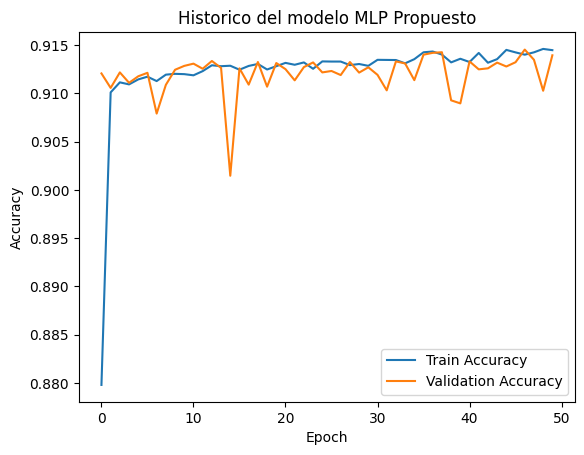

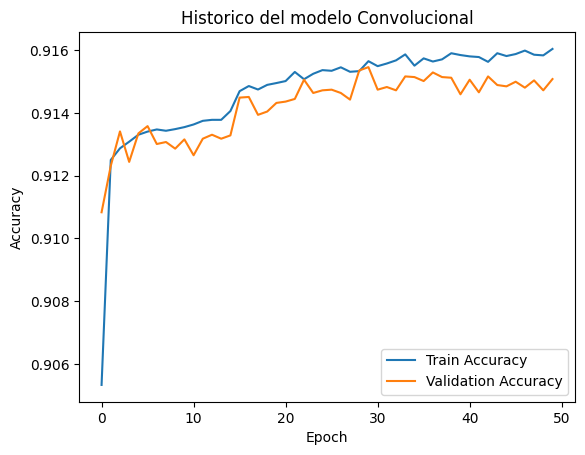

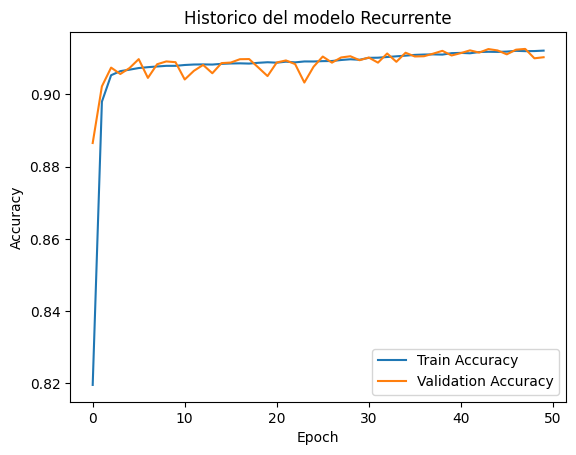

In [21]:
history_results = [history_proposed_model, history_cnn_model, history_lstm]
titles = ["MLP Propuesto", "Convolucional", "Recurrente"]
for history, title in zip(history_results, titles):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.plot(history.history['loss'], label='Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Historico del modelo {title}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### __14. Matrices de confusion y reportes de clasificacion de cada modelo__

3173/3173 [==============================] - 7s 2ms/step


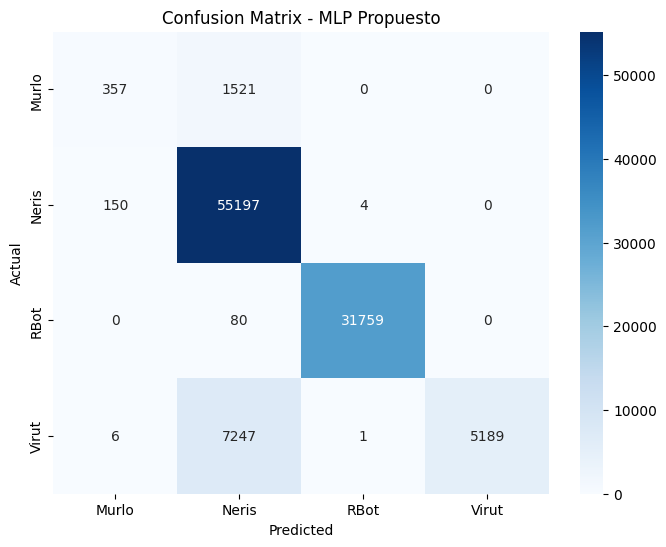

Resultados para MLP Propuesto:
              precision    recall  f1-score   support

           0       0.70      0.19      0.30      1878
           1       0.86      1.00      0.92     55351
           2       1.00      1.00      1.00     31839
           3       1.00      0.42      0.59     12443

    accuracy                           0.91    101511
   macro avg       0.89      0.65      0.70    101511
weighted avg       0.92      0.91      0.90    101511

3173/3173 [==============================] - 3s 881us/step


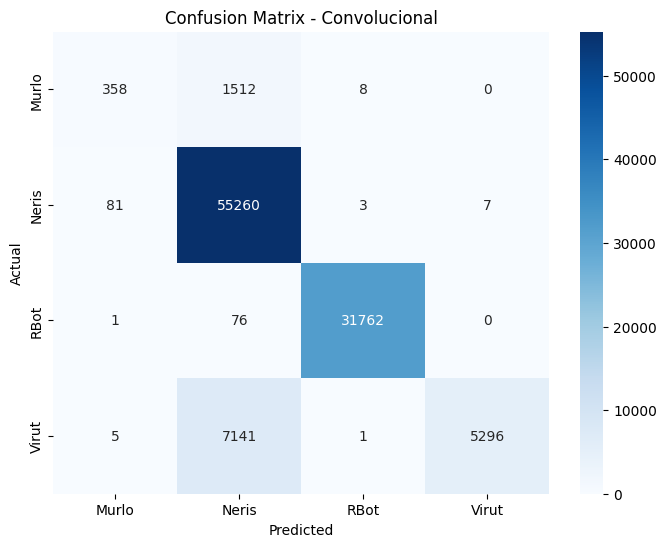

Resultados para Convolucional:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31      1878
           1       0.86      1.00      0.93     55351
           2       1.00      1.00      1.00     31839
           3       1.00      0.43      0.60     12443

    accuracy                           0.91    101511
   macro avg       0.92      0.65      0.71    101511
weighted avg       0.92      0.91      0.90    101511

3173/3173 [==============================] - 11s 3ms/step


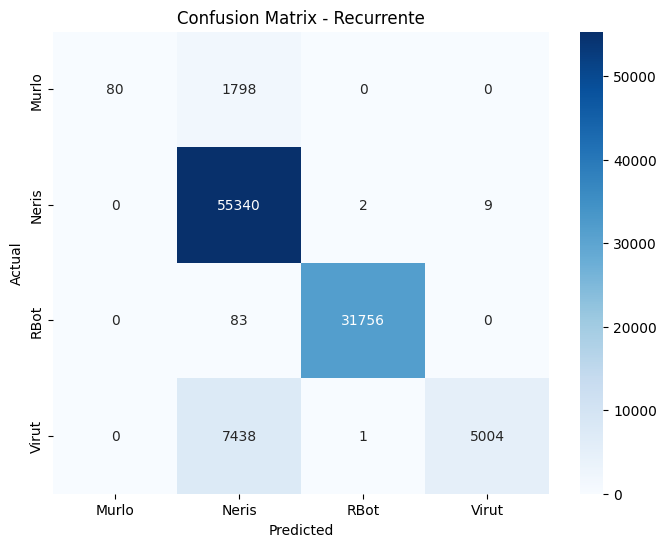

Resultados para Recurrente:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08      1878
           1       0.86      1.00      0.92     55351
           2       1.00      1.00      1.00     31839
           3       1.00      0.40      0.57     12443

    accuracy                           0.91    101511
   macro avg       0.96      0.61      0.64    101511
weighted avg       0.92      0.91      0.89    101511



In [22]:
models = [model, model_cnn, model_lstm]
for md, title in zip(models, titles):
    #predictions = model.predict(testX)
    predictions = md.predict(testX)
    predictions = predictions.argmax(axis=1) 
    #true_labels = testY.argmax(axis=1)
    true_labels = testY.copy()
    #print(true_labels)
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Murlo','Neris','RBot','Virut'], yticklabels=['Murlo','Neris','RBot','Virut'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()
    print(f"Resultados para {title}:")
    print(classification_report(true_labels, predictions))